# pytf Examples

The first section demonstrates the use of FilterBank.

The second section demonstrates the use of Spectrogram. 

In [1]:
import numpy as np
from pytf import FilterBank, Spectrogram
import matplotlib.pyplot as plt

from mspacman.generator.noise import (white, pink) # I can't share this repository yet until my paper is published.
# So in order to make this example to work on your local machine, try generating your own test signal.

In [2]:
tdur = 10
fs = 2**14
nsamp = fs * tdur

# Generate a time domain signal
t = np.linspace(0, tdur, nsamp)
sig = white(nsamp, mean=0, std=1) + pink(nsamp, mean=0, std=1)

# Convert generated signal to frequency domain
sigF = np.fft.fft(sig, axis=-1)
w = np.fft.fftfreq(sigF.size) * fs

sigF = np.fft.fftshift(sigF)
w = np.fft.fftshift(w)

# FilterBank Example

In [4]:
# Initialize the filter bank class
fb = FilterBank(nch=1, nsamp=nsamp, binsize=2**10, decimate_by=1, \
                     bandwidth=100, center_freqs=np.array([50]), freq_bands=None, order=2**10, sample_rate=fs, \
                     hilbert=False, domain='time', nprocs=1, mprocs=False,
                     logger=None)

INFO:<class 'pytf.filter.filterbank.FilterBank'>:Creating the FilterBank class.
INFO:<class 'pytf.filter.filterbank.FilterBank'>:Created the prototype filter.
INFO:<class 'pytf.filter.filterbank.FilterBank'>:Initialized FilterBank.


In [5]:
x = fb.analysis(sig, window='hanning')
_w = np.fft.fftshift(np.fft.fftfreq(fb._filts.size)) * fs

In [6]:
X = np.fft.fft(x, axis=-1)
X = np.fft.fftshift(X)

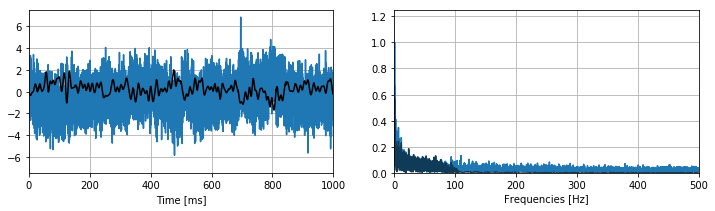

In [7]:
plt.figure(figsize=(12, 3))
plt.subplot(121)
plt.plot(t*1000, sig.flatten())
plt.plot(t*1000, x.flatten(), c='k')
plt.xlim([0, 1000])
plt.xlabel('Time [ms]')
plt.grid('on')

plt.subplot(122)
plt.plot(w, np.abs(sigF.flatten()) / np.abs(sigF).max())
plt.plot(w, np.abs(X.flatten()) / np.abs(sigF).max(), c='k', alpha=.5)

plt.xlim([0, 500])
plt.ylim([0, 1.25])
plt.xlabel('Frequencies [Hz]')
plt.grid('on')

## Notes:
Notice the slight scaling issue in the low frequencies. This is because that filter bank (at the moment) filters all signals using only one bandpass filter. A typical application of filtering from 0-100 Hz should be done in lowpass filter, but that would introduce additional complexity in the implementation and will be overlooked for now.

# Spectrogram Example

In [8]:
spec = Spectrogram(nch=1, nsamp=nsamp, sample_rate=fs, binsize=2**9, hopsize=None, overlap_factor=.5)
X_ = spec.analysis(sig)

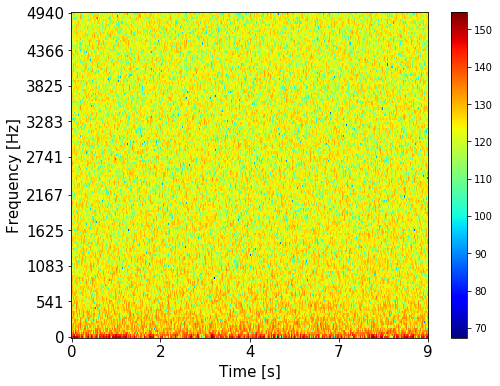

In [9]:
spec.plot_spectra(ch=None, axs=None, tlim=None, flim=(0, 5000), figsize=(8, 6), norm='db',
                  title=None, label=False, xlabel=True, ylabel=True,
                  fontsize={'ticks': 15, 'axis': 15, 'title': 20})

## Notes:
Play around with binsize argument to notice the changes in frequency resolution vs time resolution.